## Data Analysis

In this notebook, we use the Green Metric Tool API to analyse the measurements collected during simulated email user sessions. This involves processing and interpreting data related to energy consumption of basic email operations, called functional units, across different providers, assessing performance metrics, and comparing the impact of different factors such as ad-blockers and PGP encryption.


#### Load the libraries

In [1]:
import pandas as pd # For data manipulation
import numpy as np # For data manipulation
import requests # For HTTP Requests to the API
import seaborn as sns # For charts
from IPython.display import display # To dataframe displaying
import scipy.stats as stats # For stats
from itertools import combinations
import matplotlib.pyplot as plt
from datetime import datetime

import warnings

# Suppress all warnings
warnings.filterwarnings("ignore")

#Set display options to show all rows and columns
pd.set_option('display.max_rows', None)  # Show all rows
pd.set_option('display.max_columns', None)  # Show all columns
pd.set_option('display.width', None)  # Auto-detect the width
pd.set_option('display.max_colwidth', None)  # Show full content of each column

# pd.reset_option('display.max_rows')
# pd.reset_option('display.max_columns')
# pd.reset_option('display.width')
# pd.reset_option('display.max_colwidth')

#### Define the URL and other constants to query the GMT API

In [2]:
URL = 'http://api.green-coding.internal:9142'
REPO = '/home/jason/memoire/simulator'
RUNS = '/v1/runs'
NOTES = '/v1/notes/'
MEASUREMENTS = '/v1/measurements/single/'

### Define functions to:
    - get all the runs infos (test_name, run_ids, time)
    - get all run ids of tests which names include a substring
    - get the test name of a given run id
    - get the notes from a given run id
    - print the logs of a given run id
    - get the measurment of a given run id

In [3]:
# Function to get all runs
def get_runs():
    try:
        # Fetch data from the API
        response = requests.get(URL + RUNS)
        response.raise_for_status()  # Check if the request was successful
        
        data = response.json()
        
        # Convert the relevant part of the data into a DataFrame
        runs = pd.DataFrame.from_dict(data['data'])
        runs = runs[[0, 1, 4]]
        runs.columns = ['id', 'name', 'time'] 
        
        return runs
    except requests.exceptions.RequestException as e:
        print(f"Request failed: {e}")
    except ValueError as e:
        print(f"Failed to decode JSON: {e}")

# Function to get all the run IDs for a test name containing a given substring
def get_ids(substring=""):
    runs = get_runs()
    filtered_runs = runs[runs['name'].str.contains(substring, na=False)]
    return filtered_runs['id'].tolist()

# Function to get the test name of a run given its ID
def get_name(id):
    runs = get_runs()
    run = runs[runs['id'] == id]
    
    if not run.empty:
        return run.iloc[0]['name']
    else:
        return None

# Function to create the notes (i.e., logs) DataFrame from an ID
def get_notes(id):
    try:
        response = requests.get(URL + NOTES + id)
        response.raise_for_status()  # Check if the request was successful
        data = response.json()
        notes = pd.DataFrame.from_dict(data['data'])
        
        # Set the appropriate column names
        notes.columns = ['id', 'container', 'log', 'time']

        # Sort the logs by time
        notes.sort_values(by='time', ascending=False, inplace=True)
        
        return notes
        
    except Exception as e:
        print(f"Failed to fetch or process notes for ID {id}: {e}")
        # Return an empty DataFrame with the expected column names
        return pd.DataFrame(columns=['id', 'container', 'log', 'time'])

def print_logs(id):
    # print the notes (logs) for the given ID
    notes_df = get_notes(id)
    
    if notes_df.empty:
        print(f"No logs found for ID {id}.")
        return
    
    # Print the logs in order
    for index, row in notes_df.iterrows():
        print(f"Time: {row['time']}, Log: {row['log']}")


# Function to get the measurement DataFrame from an ID
def get_measurements(id):
    try:
        response = requests.get(URL + MEASUREMENTS + id)
        response.raise_for_status()  # Check if the request was successful
        data = response.json()
        measurement = pd.DataFrame.from_dict(data['data'])
        
        # Set the appropriate column names
        measurement.columns = ['detail_name', 'time', 'metric', 'value', 'unit']
        return measurement

    except Exception as e:
        print(f"Failed to fetch measurements for ID {id}: {e}")
        # Return an empty DataFrame in case of an error
        return pd.DataFrame(columns=['detail_name', 'time', 'metric', 'value', 'unit'])

### Define a DataFrame to Map Providers and Functional Units to corresponding Tests and Actions to Monitor

We use a DataFrame to map each (provider, functional unit) pair to the test containing the samples and the action to monitor within those test.

EXAMPLE :  
- Considering the 'reply' functional unit for the 'gmail' provider with adblock enabled, we look up the entry `['gmail_adblock', 'repy']`. This entry directs us to the test name `'2025_gmail_answer_adblock.json'` and specifies the name of the action to monitor: `'reply'`.

- Considering the 'attachment' functional unit (i.e. send with attachment file) for the 'mysolution' provider with adblock disabled and PGP enabled, we look up the entry `['mysolution_noadblock_pgp', 'attachment']`. This entry directs us to the test name `'2025_mysolution_attachment_noadblock_pgp.json'` and specifies the name of the action to monitor: `'send_mail'`.


In [ ]:
PROVIDERS = ['gmail', 'outlook', 'proton', 'mysolution']
ADBLOCK_CONDITION = ['enabled', 'disabled']
PGP_CONDITIONS = ['enabled', 'disabled']
FUNCTIONAL_UNITS = ['login', 'logout', 'noattachment', 'attachment', 'read', 'reply', 'delete', 'session']

def get_test_name_and_action(provider, adblock, pgp, functional_unit):
    test_name = "2025_"
    action = None
    test_name += f"{provider}_"

    if functional_unit == 'login':
        action = 'login'
        test_name += 'login_'
    elif functional_unit == 'logout':
        action = 'logout'
        test_name += 'login_'
    elif functional_unit == 'attachment':
        action = 'send_mail'
        test_name += 'attachment_'
    elif functional_unit == 'noattachment':
        action = 'send_mail'
        test_name += 'noattachment_'
    elif functional_unit == 'read':
        action = 'read_first'
        test_name += "answer_"
    elif functional_unit == 'reply':
        action = 'reply'
        test_name += "answer_"
    elif functional_unit == 'delete':
        action = 'delete_first'
        test_name += 'delete_'

    test_name += 'adblock' if adblock == 'enabled' else 'noadblock'

    if provider == 'mysolution':
        test_name += '_pgp' if pgp == 'enabled' else '_nopgp'

    test_name += '.json'

    return test_name, action
    
def get_test_name_and_action2(provider, adblock, pgp, functional_unit):
    test_name = "2025_"
    action = None
    test_name += f"{provider}_session_"

    if functional_unit == 'login':
        action = 'login'
    elif functional_unit == 'logout':
        action = 'logout'
    elif functional_unit == 'attachment':
        action = 'send_mail_5MB'
    elif functional_unit == 'noattachment':
        action = 'send_mail_0MB'
    elif functional_unit == 'read':
        action = 'read_first'
    elif functional_unit == 'reply':
        action = 'reply'
    elif functional_unit == 'delete':
        action = 'delete_first'
    elif functional_unit == 'session':
        action = 'session'

    test_name += 'adblock' if adblock == 'enabled' else 'noadblock'

    if provider == 'mysolution':
        test_name += '_pgp' if pgp == 'enabled' else '_nopgp'

    test_name += '.json'

    return test_name, action
# Generate all combinations of provider, adblock, pgp, and functional_unit
tests_and_actions = [
    [provider, adblock, pgp, functional_unit] + list(get_test_name_and_action2(provider, adblock, pgp, functional_unit))
    for provider in PROVIDERS
    for adblock in ADBLOCK_CONDITION
    for pgp in PGP_CONDITIONS
    for functional_unit in FUNCTIONAL_UNITS
    if not (pgp == 'enabled' and provider != 'mysolution')  # Exclude 'enabled' PGP for all providers except 'mysolution'
    if not (provider == 'mysolution' and adblock == 'enabled') # Exclude 'enabled' ADBLOCK for provider 'mysolution'
]

# Create the DataFrame
TESTS_AND_ACTIONS = (pd.DataFrame(tests_and_actions, columns=['PROVIDER', 'ADBLOCK_CONDITION', 'PGP_CONDITION', 'FUNCTIONAL_UNIT', 'TEST', 'ACTION']) \
    .set_index(['PROVIDER', 'ADBLOCK_CONDITION', 'PGP_CONDITION', 'FUNCTIONAL_UNIT']))


TESTS_AND_ACTIONS

TEST  \
PROVIDER   ADBLOCK_CONDITION PGP_CONDITION FUNCTIONAL_UNIT                                                 
gmail      enabled           disabled      login                         2025_gmail_session_adblock.json   
                                           logout                        2025_gmail_session_adblock.json   
                                           noattachment                  2025_gmail_session_adblock.json   
                                           attachment                    2025_gmail_session_adblock.json   
                                           read                          2025_gmail_session_adblock.json   
                                           reply                         2025_gmail_session_adblock.json   
                                           delete                        2025_gmail_session_adblock.json   
                                           session                       2025_gmail_session_adblock.json   
           disabled          disabled      login                       2025_gmail_session_noadblock.json   
                                           logout                      2025_gmail_session_noadblock.json   
                                           noattachment                2025_gmail_session_noadblock.json   
                                           attachment                  2025_gmail_session_noadblock.json   
                                           read                        2025_gmail_session_noadblock.json   
                                           reply                       2025_gmail_session_noadblock.json   
                                           delete                      2025_gmail_session_noadblock.json   
                                           session                     2025_gmail_session_noadblock.json   
outlook    enabled           disabled      login                       2025_outlook_session_adblock.json   
                                           logout                      2025_outlook_session_adblock.json   
                                           noattachment                2025_outlook_session_adblock.json   
                                           attachment                  2025_outlook_session_adblock.json   
                                           read                        2025_outlook_session_adblock.json   
                                           reply                       2025_outlook_session_adblock.json   
                                           delete                      2025_outlook_session_adblock.json   
                                           session                     2025_outlook_session_adblock.json   
           disabled          disabled      login                     2025_outlook_session_noadblock.json   
                                           logout                    2025_outlook_session_noadblock.json   
                                           noattachment              2025_outlook_session_noadblock.json   
                                           attachment                2025_outlook_session_noadblock.json   
                                           read                      2025_outlook_session_noadblock.json   
                                           reply                     2025_outlook_session_noadblock.json   
                                           delete                    2025_outlook_session_noadblock.json   
                                           session                   2025_outlook_session_noadblock.json   
proton     enabled           disabled      login                        2025_proton_session_adblock.json   
                                           logout                       2025_proton_session_adblock.json   
                                           noattachment                 2025_proton_session_adblock.json   
                                           attachment                   2025_proton_session_adblock.json

# Metadata Collection and Sample Counting

We want to collect metadata related to energy measurements for different **providers** and **functional units**. It includes the following steps:

- **`collect_metadata`**: Fetches metadata for a specific provider and functional unit, including start and end timestamps.
- **`collect_all_metadata`**: Collects metadata for all providers and functional units.

We also want to monitor the number of valid samples we have so far. We define:

- **`count_distinct_samples`**: Counts valid and missing samples based on unique start and end timestamps.

We finally filter the data to keep the **100 most recent samples** for each `(provider, functional unit)`.


In [5]:
import pandas as pd


def convert_to_microseconds(date_str):
    """
    Convert a date string in 'dd-mm-yyyy' format to microseconds since the epoch.
    
    Args:
        date_str (str): The date string in 'dd-mm-yyyy' format.
    
    Returns:
        int: The corresponding timestamp in microseconds since epoch.
    """
    if date_str:
        dt = datetime.strptime(date_str, "%d-%m-%Y")
        return int(dt.timestamp() * 1e6)  # Convert to microseconds
    return None

def collect_metadata(provider, adblock, pgp, functional_unit, test_name, action, from_date=None, till_date=None):
    """
    Collect metadata required to fetch energy measurements.
    This includes gathering the run ID and the time period when a functional unit was performed.
    A sample is considered valid if no error occurred while performing the functional unit.

    Args:
        provider (str): The provider for which metadata is being collected.
        adblock (str): The adblock condition: enabled/disabled.
        pgp (str): The pgp condition: enabled/disabled.
        functional_unit (str): The functional unit to monitor.
        test_name (str): The name of the test.
        action (str): The action that triggers the start/end logs.
        from_date (str, optional): Start date in 'dd-mm-yyyy' format. If None, no start limit is applied.
        till_date (str, optional): End date in 'dd-mm-yyyy' format. If None, no end limit is applied.

    Returns:
        pd.DataFrame: A DataFrame containing metadata with columns:
                      ['TEST', 'RUN_ID', 'PROVIDER', 'ADBLOCK_CONDITION', 'PGP_CONDITION', 
                       'FUNCTIONAL_UNIT', 'START_TS', 'END_TS'].
    """
    
    columns = ['TEST', 'RUN_ID', 'PROVIDER', 'ADBLOCK_CONDITION', 'PGP_CONDITION', 'FUNCTIONAL_UNIT', 'START_TS', 'END_TS']
    metadata_records = []  # List to store metadata records
    ids = get_ids(test_name)  # Fetch the test run IDs
    
    # Convert from_date and till_date to microseconds since epoch
    from_ts = convert_to_microseconds(from_date)
    till_ts = convert_to_microseconds(till_date)

    for run_id in ids:
        logs = get_notes(run_id)  # Get logs for the run
        end_log_time = None  # Variable to track the latest "END" log timestamp

        for _, row in logs.iterrows():
            log_message = row['log']
            timestamp = row['time']

            # Check if the timestamp fits within the date range (if provided)
            if from_ts and timestamp < from_ts:
                continue  # Skip records that are before the 'from' time
            if till_ts and timestamp > till_ts:
                continue  # Skip records that are after the 'till' time

            # Detect end log for the specific action
            if f"END: {action}" in log_message:
                end_log_time = timestamp
                continue

            # Invalidate end time if there's an error during action execution
            if 'ERROR' in log_message or 'stacktrace' in log_message:
                end_log_time = None
                continue

            # Collect metadata once a valid start-end pair is found
            if f"START: {action}" in log_message and end_log_time is not None:
                metadata_records.append((test_name, run_id, provider, adblock, pgp, functional_unit, timestamp, end_log_time))
                end_log_time = None  # Reset after recording
    
    return pd.DataFrame(metadata_records, columns=columns)



def collect_all_metadata(from_date=None, till_date=None):
    """
    Collect metadata for all providers and functional units.
    """
    metadata_list = [
        collect_metadata(provider, adblock, pgp, functional_unit, row['TEST'], row['ACTION'], from_date, till_date)
        for (provider, adblock, pgp, functional_unit), row in TESTS_AND_ACTIONS.iterrows()
    ]

    return pd.concat(metadata_list, ignore_index=True,)

def count_distinct_samples(metadata: pd.DataFrame):
    """
    Count the number of valid samples for each (provider, functional_unit) combination.
    A valid sample is defined as a unique pair of start and end timestamps for each (TEST, ACTION).

    Args:
        metadata (pd.DataFrame): The metadata DataFrame to count samples from.

    Returns:
        pd.DataFrame: A DataFrame containing the sample counts and missing sample counts.
    """
    return (metadata.groupby(['PROVIDER', 'ADBLOCK_CONDITION', 'PGP_CONDITION', 'FUNCTIONAL_UNIT'])
                .agg(SAMPLE_COUNT=('START_TS', 'count'), 
                    MISSING_SAMPLES=('START_TS', lambda x: max(0, 100 - x.count())))  # Count missing samples
            )

In [6]:
def collect_test_ids_no_send_mail_0MB(ids = None):
    """
    Collect the test IDs containing '_session' and ensure that no logs for these tests
    contain the string 'send_mail_0MB'. Also include the date from the log's 'time' column.
    
    Args:
        None (the original function does not take arguments).
        
    Returns:
        pd.DataFrame: DataFrame containing test IDs, test names, and the log date.
    """
    # This will hold the IDs of tests to be returned
    invalid_test_ids = []
    
    # Get all tests ids that have '_session' in their name
    if ids is None:
        ids = get_ids('_session')
    
    for run_id in ids:
        logs = get_notes(run_id)  # Get logs for this run
        contains_send_mail_0MB = 0
        contains_send_mail_5MB = 0
        login = False
        logout = False
        read = False
        delete = False
        reply = False
        
        for _, row in logs.iterrows():
            log_message = row['log']
            log_time = pd.to_datetime(row['time'], unit='us')  # Convert microseconds to datetime
            
            # If any log contains 'send_mail_0MB', mark the test as invalid
            if 'END: send_mail_0MB' in log_message:
                contains_send_mail_0MB = True
            if 'END: send_mail_5MB' in log_message:
                contains_send_mail_5MB = True
            if 'END: login' in log_message:
                login = True
            if 'END: logout' in log_message:
                logout = True
            if 'END: read_first' in log_message:
                read = True
            if 'END: delete_first' in log_message:
                delete = True
            if 'END: reply' in log_message:
                reply = True
            if 'END: session' in log_message:
                session = True
        
        
        # If no 'send_mail_0MB' found in the logs, add the test run ID, name, and date
        if  not (contains_send_mail_0MB and \
            contains_send_mail_5MB and \
            login and \
            logout and \
            read and \
            delete and \
            reply and \
            session) :
            invalid_test_ids.append((run_id, get_name(run_id), log_time))
    
    return pd.DataFrame(data=invalid_test_ids, columns=['Test ID', 'Test Name', 'Log Date'])

# Example usage:
#df = collect_test_ids_no_send_mail_0MB()
#df
#print_logs(df['Test ID'][0])

In [7]:
# Collect the full metadata DataFrame
metadata = collect_all_metadata(from_date='18-02-2025')

# # Group by the relevant columns and apply sorting and filtering within each group
# filtered_metadata = metadata.groupby(['PROVIDER', 'ADBLOCK_CONDITION', 'PGP_CONDITION', 'FUNCTIONAL_UNIT'], group_keys=False) \
#                                    .apply(lambda x: x.sort_values(by='START_TS', ascending=False))

# Count distinct test-action pairs for the filtered metadata
count_distinct_samples(metadata)


SAMPLE_COUNT  \
PROVIDER   ADBLOCK_CONDITION PGP_CONDITION FUNCTIONAL_UNIT                 
gmail      disabled          disabled      attachment                200   
                                           delete                    207   
                                           login                     200   
                                           logout                    200   
                                           noattachment              200   
                                           read                      400   
                                           reply                     193   
                                           session                   193   
           enabled           disabled      attachment                150   
                                           delete                    151   
                                           login                     150   
                                           logout                    150   
                                           noattachment              150   
                                           read                      300   
                                           reply                     149   
                                           session                   149   
mysolution disabled          disabled      attachment                200   
                                           delete                    190   
                                           login                     200   
                                           logout                    200   
                                           noattachment              200   
                                           read                      392   
                                           reply                     190   
                                           session                   178   
                             enabled       attachment                 60   
                                           delete                     60   
                                           login                      60   
                                           logout                     60   
                                           noattachment               60   
                                           read                      124   
                                           reply                      60   
                                           session                    56   
outlook    disabled          disabled      attachment                150   
                                           delete                    143   
                                           login                     150   
                                           logout                    150   
                                           noattachment              150   
                                           read                      295   
                                           reply                     144   
                                           session                   134   
           enabled           disabled      attachment                120   
                                           delete                    120   
                                           login                     120   
                                           logout                    120   
                                           noattachment              120   
                                           read                      240   
                                           reply                     120   
                                           session                   118   
proton     disabled          disabled      attachment                170   
                                           delete                    171   
                                           login                     170   
                                

### Create DataFrames for Each Metric

In this section, we will generate a DataFrame for each metric listed in the METRICS list. Each DataFrame is structured with providers as rows and actions as columns. The cells contain lists of measurement values collected from multiple runs.

In [8]:
# First we check which metric we have at our disposal
test_id = get_ids("2025")[0]
print(get_measurements(test_id)[['metric', 'unit']].drop_duplicates())

                                  metric   unit
0          cpu_energy_rapl_msr_component     mJ
29731   cpu_utilization_cgroup_container  Ratio
59176      cpu_utilization_procfs_system  Ratio
88883   memory_energy_rapl_msr_component     mJ
118622     memory_total_cgroup_container  Bytes
148136       network_io_cgroup_container  Bytes
177622     psu_energy_ac_xgboost_machine     mJ


In [19]:
METRICS = [
    'CPU_ENERGY',                   # cpu_energy_rapl_msr_component
    'MEMORY_ENERGY',                # memory_energy_rapl_msr_component
    'NETWORK_IO',                   # network_io_cgroup_container
    'ESTIMATED_MACHINE_ENERGY',     # psu_energy_ac_xgboost_machine
    'DURATION']

COMPUTED_METRICS = ['CPU_POWER',
                    'MEMORY_POWER',
                    'ESTIMATED_MACHINE_POWER']
UNITS = {
    'CPU_ENERGY': 'mJ',
    'MEMORY_ENERGY': 'mJ',
    'NETWORK_IO' : 'Byte',
    'ESTIMATED_MACHINE_ENERGY' : 'mJ',
    'DURATION' : 'µs',
    'CPU_POWER' : 'W',
    'MEMORY_POWER' : 'W',
    'ESTIMATED_MACHINE_POWER' : 'W'
}

### Collect and Organise Metric Data into a Single DataFrame

**Gathering Measurement Data:**

In the `get_data` function, we collect measurement data for each sample in the `metadata` DataFrame. We extract key metadata, including test names, run IDs, provider names, adblock conditions, pgp condition, functional units, and the start and end timestamps for each sample. For each time period, we then compute the energy-related metrics—such as memory energy, CPU energy, estimated machine energy, and network I/O—using the `get_metric_stat` function.

**Storing the Collected Data:**

We store the computed values in a DataFrame. The columns of this DataFrame are: `TEST`, `RUN_ID`, `PROVIDER`, `FUNCTIONAL_UNIT`, `START_TS`, `DURATION`, `MEMORY_ENERGY`, `CPU_ENERGY`, `ESTIMATED_MACHINE_ENERGY`, and `NETWORK_IO`.

By bringing all the metric values together in one DataFrame, we make it easier to export the data to a CSV file and reload it later for further analysis. This approach ensures we don’t need to recompute the metrics every time we need the data.


In [21]:
def get_metric_stat(measurements, metric, start_ts, end_ts, func):

    # Filter to keep records of the desired metric
    measurements = measurements[measurements['metric'] == metric]
    # Filter to keep records in desired period
    measurements = measurements[(measurements['time'] >= start_ts) & (measurements['time'] < end_ts)]
    # Compute the statistic
    stat = func(measurements['value'])

    return stat

def get_data(metadata:pd.DataFrame):

    data_records = []  # Store tuples for DataFrame creation

    for run_id, run_metadata in metadata.groupby('RUN_ID') :

        # Get measurment for the run
        run_measurements = get_measurements(run_id)
        run_measurements.sort_values(by='time', ascending=True, inplace=True)

        for _, row in run_metadata.iterrows():

            # Extract Metadata:
            test = row['TEST']
            provider = row['PROVIDER']
            adblock_condition = row['ADBLOCK_CONDITION'] 
            pgp_condition = row['PGP_CONDITION']
            functional_unit = row['FUNCTIONAL_UNIT']
            start_ts = row['START_TS']
            end_ts = row['END_TS']
            duration = end_ts - start_ts

            # Compute Data
            memory_energy = get_metric_stat(run_measurements, 'memory_energy_rapl_msr_component', start_ts, end_ts, sum)
            cpu_energy = get_metric_stat(run_measurements, 'cpu_energy_rapl_msr_component', start_ts, end_ts, sum)
            estimated_machine_energy = get_metric_stat(run_measurements, 'psu_energy_ac_xgboost_machine', start_ts, end_ts, sum)
            network_io = get_metric_stat(run_measurements, 'network_io_cgroup_container', start_ts, end_ts + 10e7, lambda x: x.iloc[-1] - x.iloc[0] if len(x) > 1 else 0)

            # Store records
            data_records.append((test,
                                run_id,
                                provider,
                                adblock_condition,
                                pgp_condition,
                                functional_unit,
                                start_ts,
                                duration,
                                memory_energy,
                                cpu_energy,
                                estimated_machine_energy,
                                network_io))
        
    data = pd.DataFrame(  columns = ['TEST',
                                    'RUN_ID',
                                    'PROVIDER',
                                    'ADBLOCK_CONDITION',
                                    'PGP_CONDITION',
                                    'FUNCTIONAL_UNIT',
                                    'START_TS',
                                    'DURATION',
                                    'MEMORY_ENERGY',
                                    'CPU_ENERGY',
                                    'ESTIMATED_MACHINE_ENERGY',
                                    'NETWORK_IO'],
                        data = data_records).sort_values(by=[   'PROVIDER',
                                                                'ADBLOCK_CONDITION',
                                                                'PGP_CONDITION',
                                                                'FUNCTIONAL_UNIT'])
    return data

In [22]:
data = get_data(metadata=metadata)
data.to_csv('2025_data_test.csv', index=False)

# START FROM HERE

In [12]:
data = pd.read_csv('2025_data_test.csv')

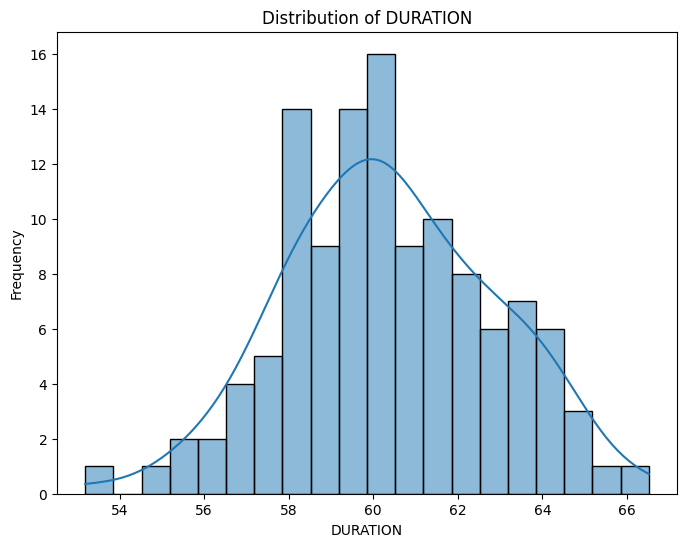

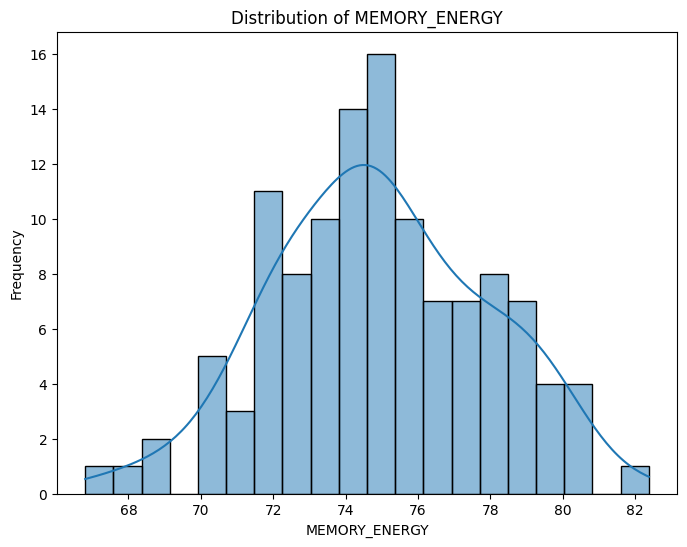

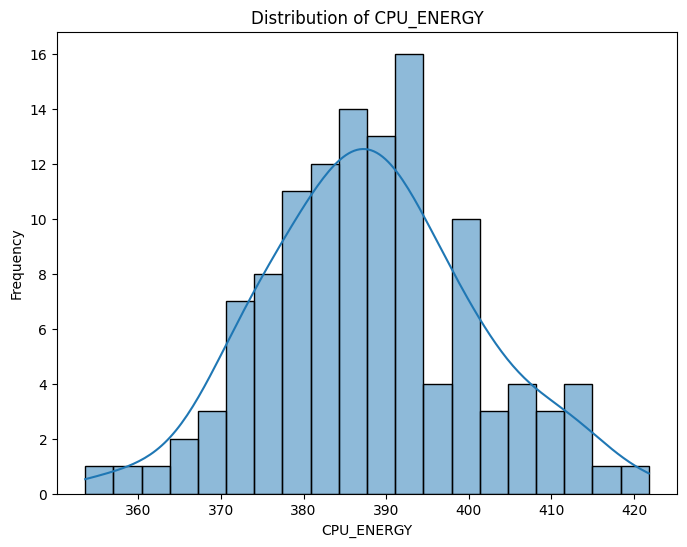

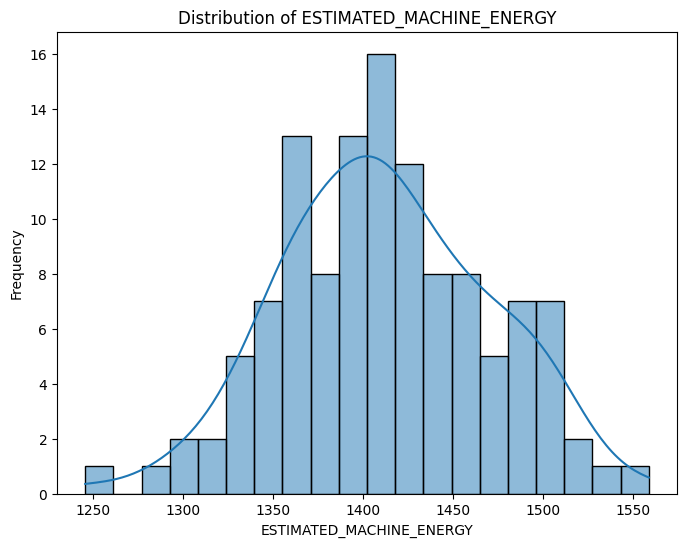

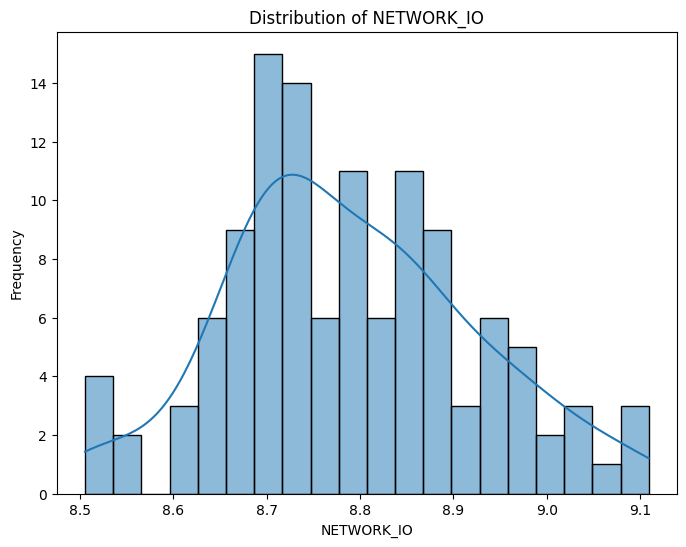

In [35]:
# Plot distribution
from datetime import datetime
def get_samples(data, functional_unit, provider, adblock='disabled', pgp='disabled', columns=['DURATION', 'MEMORY_ENERGY', 'CPU_ENERGY', 'ESTIMATED_MACHINE_ENERGY', 'NETWORK_IO']):
    return data[(data['PROVIDER'] == provider) &
                (data['ADBLOCK_CONDITION'] == adblock) &
                (data['PGP_CONDITION'] == pgp) &
                (data['FUNCTIONAL_UNIT'] == functional_unit)][columns]

def plot_distribution(data, functional_unit, provider, adblock='disabled', pgp='disabled', columns=['DURATION', 'MEMORY_ENERGY', 'CPU_ENERGY', 'ESTIMATED_MACHINE_ENERGY', 'NETWORK_IO']):
    df = get_samples(data, functional_unit, provider, adblock, pgp, columns)
    for column in df.select_dtypes(include='number').columns:
        plt.figure(figsize=(8, 6))
        sns.histplot(df[column], kde=True, bins=20)
        plt.title(f'Distribution of {column}')
        plt.xlabel(column)
        plt.ylabel('Frequency')
        plt.show()

plot_distribution(clean_data, 'attachment', 'gmail', 'enabled', 'disabled', columns=[ 'DURATION', 'MEMORY_ENERGY', 'CPU_ENERGY', 'ESTIMATED_MACHINE_ENERGY', 'NETWORK_IO'])

# Fetch the data
sub_data = get_samples(data, 'noattachment', 'gmail', 'disabled', 'disabled', columns=['START_TS', 'DURATION', 'MEMORY_ENERGY', 'CPU_ENERGY', 'ESTIMATED_MACHINE_ENERGY', 'NETWORK_IO'])

# Get today's date
today = datetime.today().date()

# Convert 'START_TS' to datetime (microseconds to datetime)
sub_data['START_TS'] = pd.to_datetime(sub_data['START_TS'], unit='us')

# Filter for rows where 'START_TS' is from today
sub_data_today = sub_data[sub_data['START_TS'].dt.date == today]

In [24]:

def remove_outliers(data, columns, group_columns=['PROVIDER', 'ADBLOCK_CONDITION', 'PGP_CONDITION', 'FUNCTIONAL_UNIT']):
    """
    Removes outliers from the dataframe using the IQR method per group (PROVIDER, FUNCTIONAL_UNIT).
    """
    # Iterate over each metric (column)
    for col in columns:
        # Define a function to remove outliers for each group
        def remove_outliers_for_group(group_df):
            Q1 = group_df[col].quantile(0.25)
            Q3 = group_df[col].quantile(0.75)
            IQR = Q3 - Q1
            lower_bound = Q1 - 1.5 * IQR
            upper_bound = Q3 + 1.5 * IQR
            return group_df[(group_df[col] >= lower_bound) & (group_df[col] <= upper_bound)]
        
        # Apply the function to remove outliers for each group
        data = data.groupby(group_columns).apply(remove_outliers_for_group).reset_index(drop=True)
    
    return data

# Columns to remove outliers for
columns_to_check = ['DURATION', 'MEMORY_ENERGY', 'CPU_ENERGY', 'ESTIMATED_MACHINE_ENERGY', 'NETWORK_IO']

# Remove outliers
clean_data = remove_outliers(data, columns=columns_to_check)

# Display the numbers of valid samples left
count_distinct_samples(clean_data)

SAMPLE_COUNT  \
PROVIDER   ADBLOCK_CONDITION PGP_CONDITION FUNCTIONAL_UNIT                 
gmail      disabled          disabled      attachment                160   
                                           delete                     66   
                                           login                     165   
                                           logout                    141   
                                           noattachment              192   
                                           read                      309   
                                           reply                     150   
                                           session                   151   
           enabled           disabled      attachment                119   
                                           delete                     56   
                                           login                     121   
                                           logout                    106   
                                           noattachment              148   
                                           read                      236   
                                           reply                     117   
                                           session                   120   
mysolution disabled          disabled      attachment                164   
                                           delete                    169   
                                           login                     165   
                                           logout                    165   
                                           noattachment              140   
                                           read                      386   
                                           reply                     169   
                                           session                   132   
                             enabled       attachment                 53   
                                           delete                     49   
                                           login                      41   
                                           logout                     48   
                                           noattachment               45   
                                           read                      100   
                                           reply                      53   
                                           session                    41   
outlook    disabled          disabled      attachment                113   
                                           delete                    103   
                                           login                     115   
                                           logout                     96   
                                           noattachment              136   
                                           read                      238   
                                           reply                      89   
                                           session                   110   
           enabled           disabled      attachment                 89   
                                           delete                     62   
                                           login                      96   
                                           logout                     86   
                                           noattachment              114   
                                           read                      202   
                                           reply                      95   
                                           session                    86   
proton     disabled          disabled      attachment                134   
                                           delete                    110   
                                           login                     108   
                                

In [25]:
def get_power_data(data:pd.DataFrame):
    new_columns = ['CPU_POWER', 'MEMORY_POWER', 'ESTIMATED_MACHINE_POWER']
    columns = ['CPU_ENERGY', 'MEMORY_ENERGY', 'ESTIMATED_MACHINE_ENERGY']
    for i in range(len(new_columns)):
        data[new_columns[i]] = (data[columns[i]]/data['DURATION'])

def change_scale(data):
    for metric, unit in UNITS.items():
        if metric in data.columns:
            if unit == 'mJ':
                data[metric] = data[metric]/1e3
                UNITS[metric] = 'J'
            if unit == 'Byte':
                data[metric] = data[metric]/1e6
                UNITS[metric] = 'MB'
            if unit == 'µs':
                data[metric] = data[metric]/1e6
                UNITS[metric] = 's'

                
change_scale(clean_data)
get_power_data(clean_data)

### Define a function to get the means and standard deviation of each test

In [26]:
def compute_means_and_stds(data:pd.DataFrame):

    return data.groupby(['PROVIDER', 'ADBLOCK_CONDITION', 'PGP_CONDITION', 'FUNCTIONAL_UNIT']) \
                .agg({  'DURATION': ['mean', 'std'],
                        'MEMORY_ENERGY': ['mean', 'std'],
                        'CPU_ENERGY': ['mean', 'std'],
                        'ESTIMATED_MACHINE_ENERGY': ['mean', 'std'],
                        'NETWORK_IO': ['mean', 'std'],
                        'MEMORY_POWER': ['mean', 'std'],
                        'CPU_POWER': ['mean', 'std'],
                        'ESTIMATED_MACHINE_POWER': ['mean', 'std'],
                    })


### Define a function to plot the mean results with their standard deviations

In [27]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

def plot_metrics_bars(means_and_stds: pd.DataFrame, metric: str):
    # Define colors for providers and conditions
    colors = {
        'gmail': {'adblock': '#ABB0AC', 'noadblock': '#636964'},
        'outlook': {'adblock': '#97BCD8', 'noadblock': '#366990'},
        'proton': {'adblock': '#F8B18B', 'noadblock': '#F26419'},
        'mysolution': {'pgp': '#FAD389', 'nopgp': '#F6AE2D'}
    }

    # Create a new figure
    fig, ax = plt.subplots(figsize=(12, 8))

    # Get unique functional units and calculate positions
    functional_units = FUNCTIONAL_UNITS
    num_conditions = len(means_and_stds) // len(functional_units)  # Number of provider-condition combinations per functional unit
    bar_width = 0.8 / num_conditions  # Space bars based on the number of provider-condition combinations
    index = np.arange(len(functional_units))  # Set x-axis positions for the functional units

    # Iterate over each functional unit to plot the bars
    for j, functional_unit in enumerate(functional_units):
        # Extract rows for the current functional unit
        rows = means_and_stds.xs(functional_unit, level='FUNCTIONAL_UNIT')

        # Iterate over the provider/condition combinations for the functional unit
        for i, (idx, row) in enumerate(rows.iterrows()):
            provider, adblock, pgp = idx
            mean_value, std_value = row[metric]['mean'], row[metric]['std']

            # Determine the condition labels for adblock and pgp
            adblock_label = 'adblock' if adblock == 'enabled' else 'noadblock'
            pgp_label = 'pgp' if pgp == 'enabled' else 'nopgp'

            # Get the appropriate color for the given provider and condition
            if provider == 'mysolution':
                color = colors['mysolution'].get(pgp_label, 'gray')  # Only pgp/nopgp for mysolution
            else:
                color = colors.get(provider, {'adblock': 'gray', 'noadblock': 'darkgray'}).get(adblock_label, 'gray')

            # Calculate bar position based on functional unit and provider-condition index
            bar_position = index[j] + i * bar_width

            # Label the first bar of each functional unit with provider/condition info
            label = f'{provider} - {adblock_label}/{pgp_label}' if j == 0 else None

            # Plot the bar and add error bars
            ax.bar(bar_position, mean_value, bar_width, color=color, edgecolor='k', label=label)
            ax.errorbar(bar_position, mean_value, yerr=std_value, fmt='o', color='black', capsize=5)

    # Set the labels, title, and ticks
    ax.set_xlabel('Functional Units')
    ax.set_ylabel(f'Mean Value and Standard Deviation for {metric}')
    ax.set_title(f'{metric} ({UNITS.get(metric, "")}) by Provider and Functional Unit')
    ax.set_xticks(index + bar_width * (num_conditions - 1) / 2)
    ax.set_xticklabels(functional_units)

    # Add the legend
    ax.legend()

    # Adjust layout and display
    plt.tight_layout()
    plt.show()


In [25]:
data_test = get_samples(clean_data, 'login', 'outlook', 'disabled', 'disabled')
print(len(data_test[data_test['CPU_ENERGY']>200]))

0


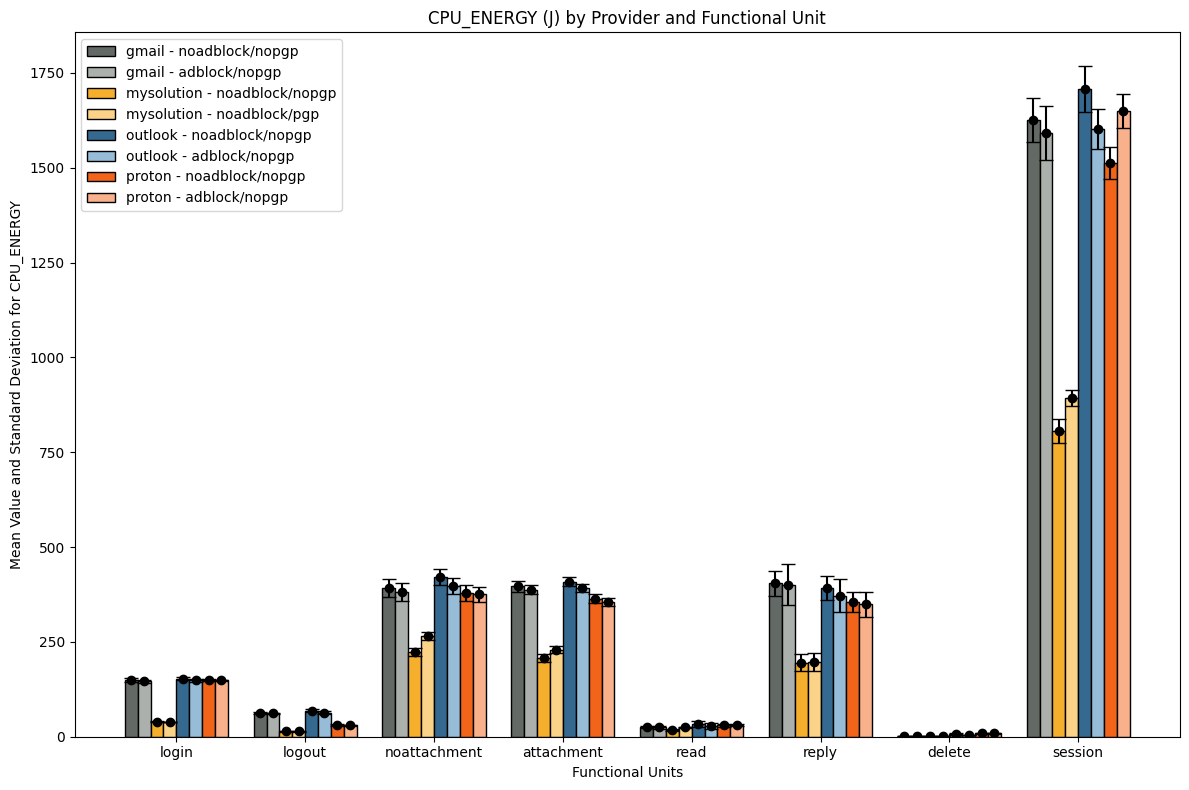

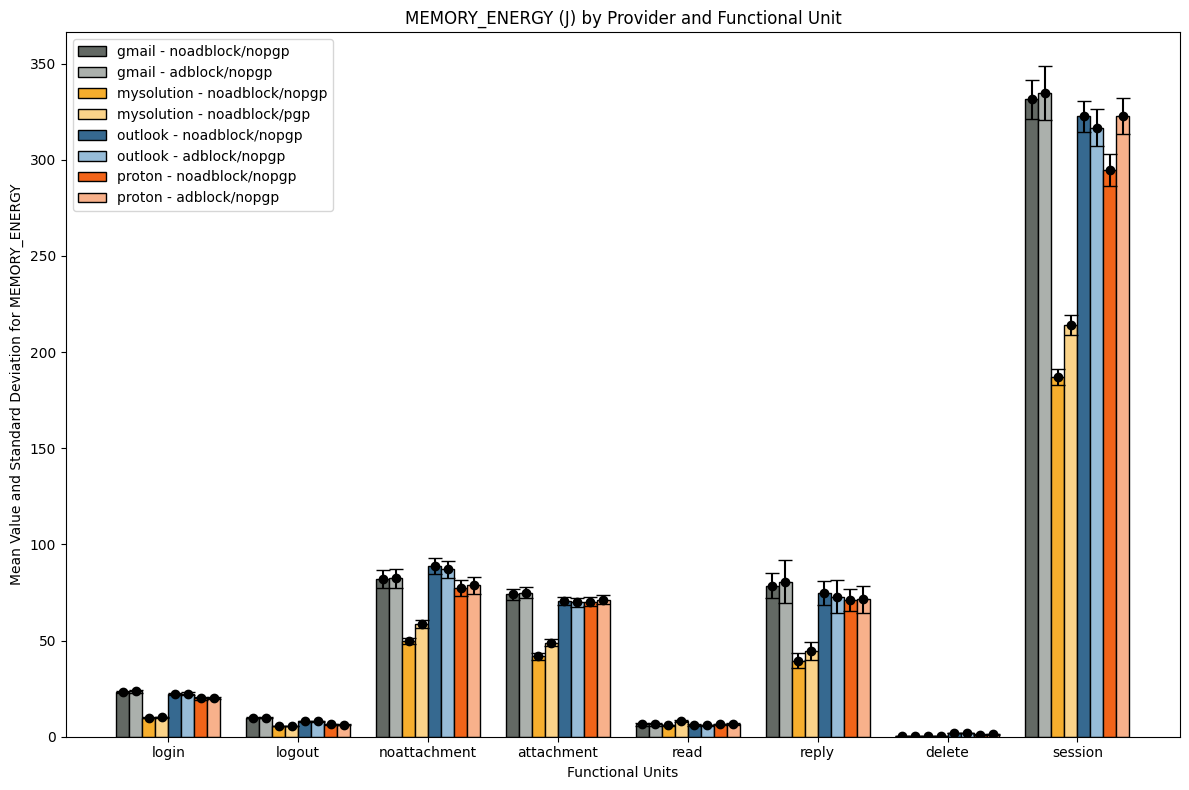

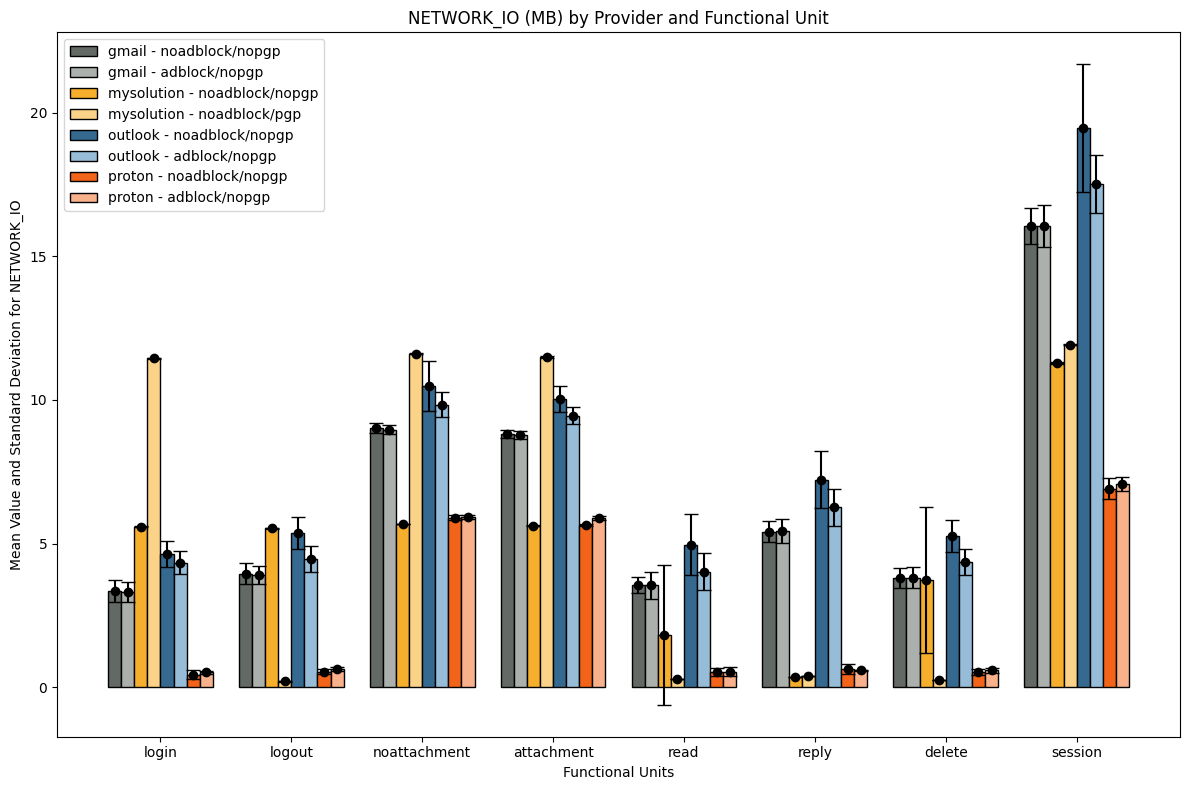

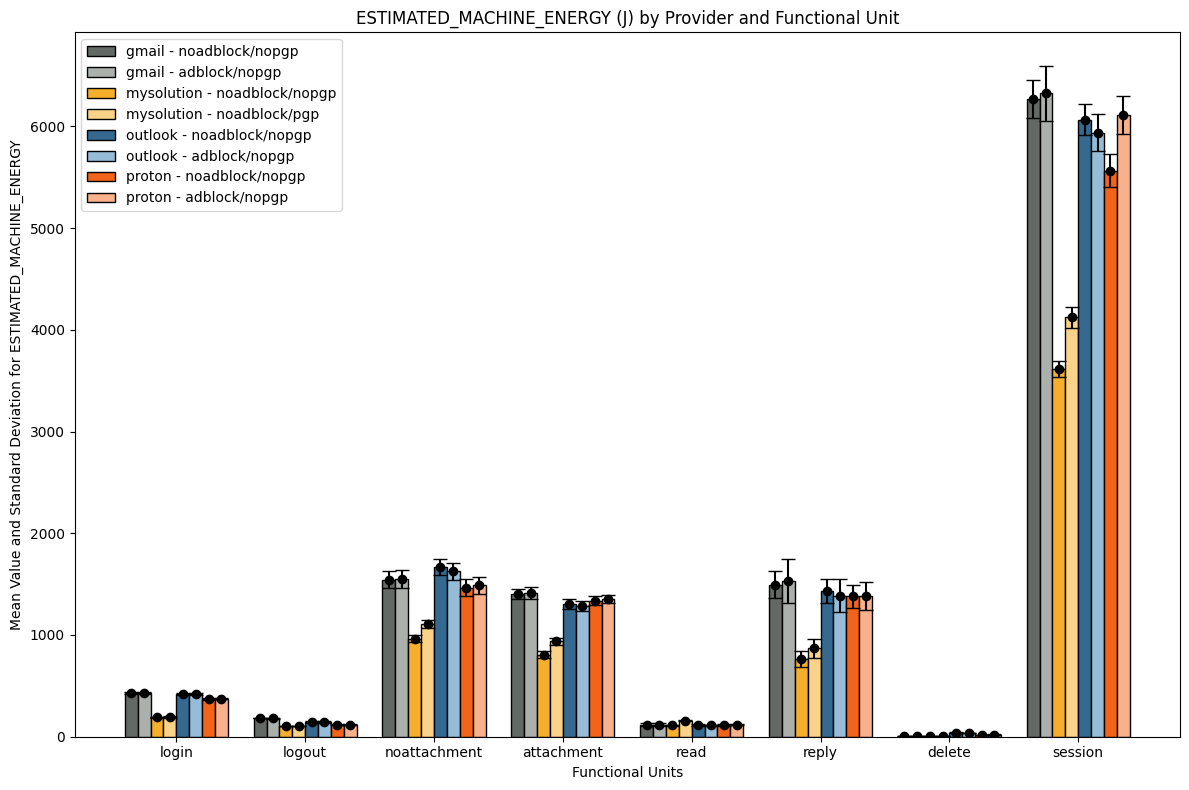

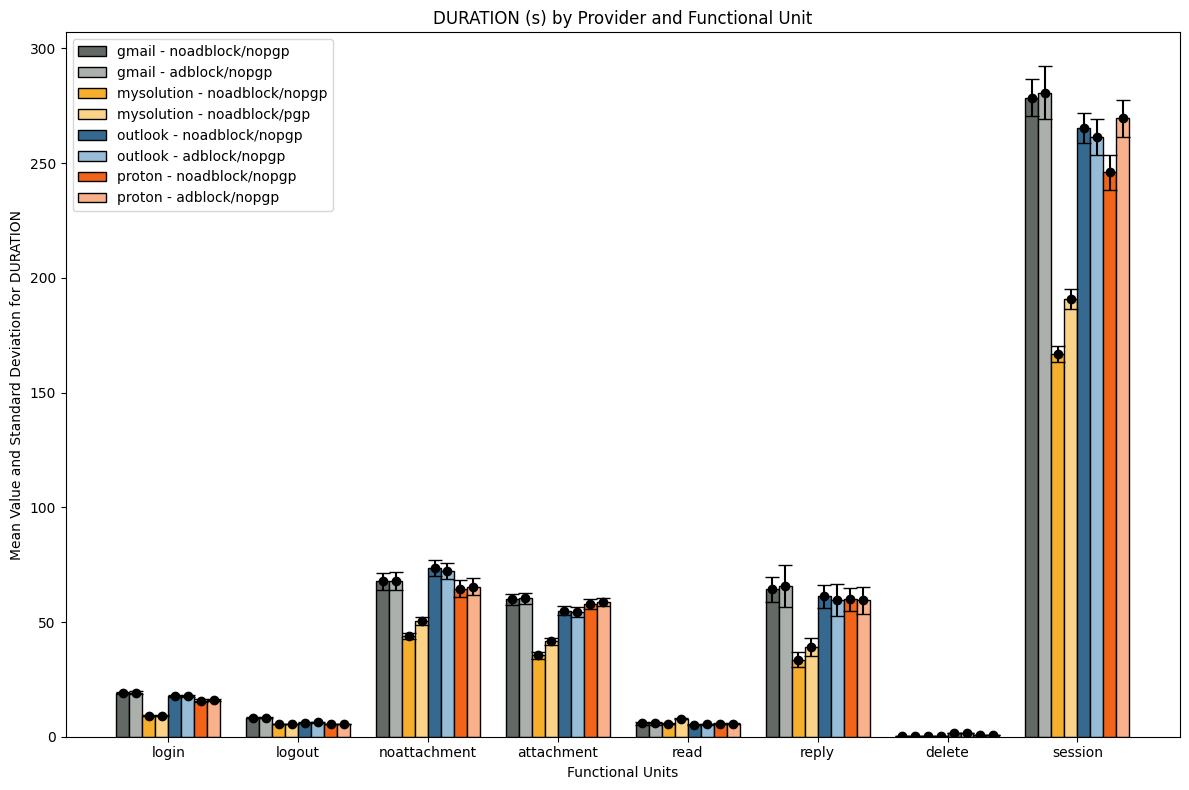

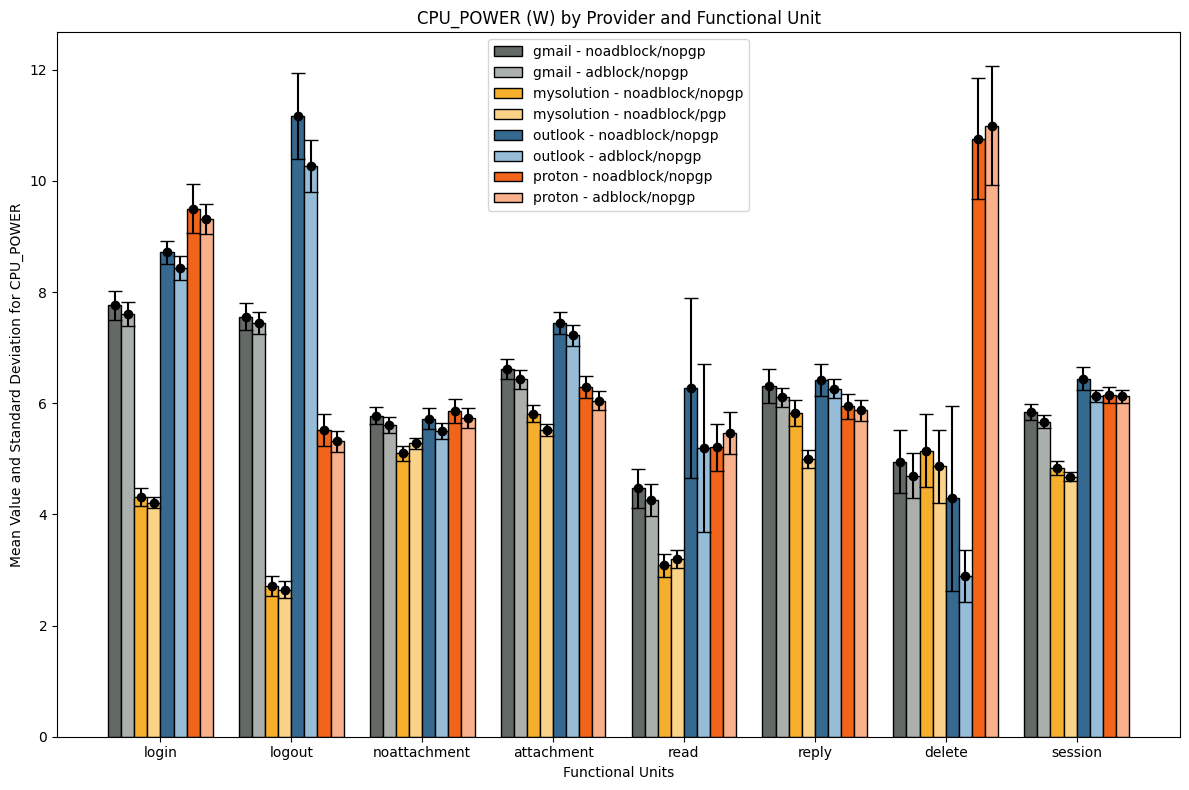

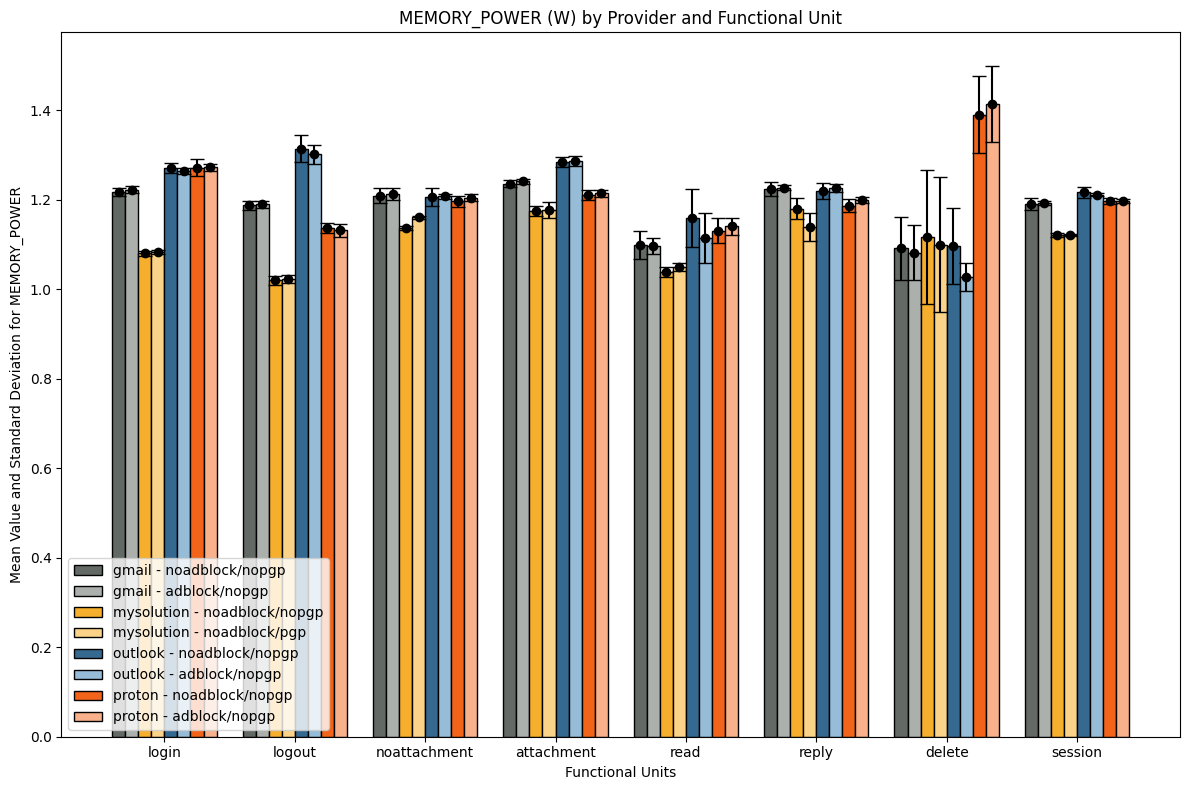

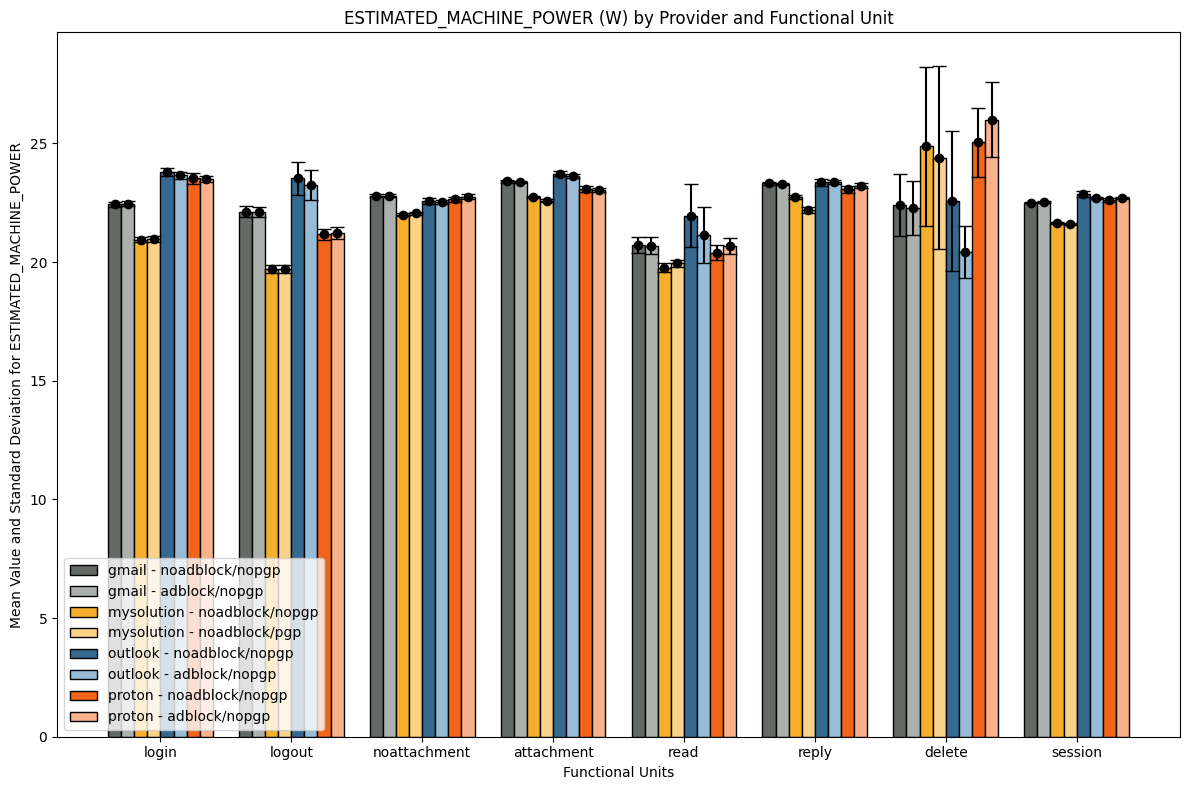

In [28]:
means_and_stds = compute_means_and_stds(clean_data)

for metric in METRICS + COMPUTED_METRICS:
    plot_metrics_bars(means_and_stds, metric)

### Statistical Significance Testing

**Comparing Adblock vs. No-Adblock:**

The function compares each pair of adblock and no-adblock conditions in the DataFrame to assess statistical significance. It uses a paired t-test to determine if the differences in metrics between these conditions are significant.

**Args:**
- `df (pd.DataFrame)`: Contains metrics for each provider and action, with pairs like 'gmail_adblock' and 'gmail_noadblock'.
- `alpha (float)`: Significance level (default is 0.05).

**Returns:**
- `dict`: Results include p-values and significance status for each action and provider.

**Comparing Proton vs. Other Providers (Same Adblock Condition):**

This function evaluates the statistical significance of differences between Proton and other providers (Gmail, Outlook) under the same adblock condition.

**Args:**
- `metric_df (pd.DataFrame)`: Contains metrics for each provider and action.

**Returns:**
- `dict`: Results of significance tests for each action.

In [ ]:
def get_samples(data, functional_unit, provider, adblock='disabled', pgp='disabled',
                columns=['DURATION', 'MEMORY_ENERGY', 'CPU_ENERGY', 'ESTIMATED_MACHINE_ENERGY', 'NETWORK_IO']+COMPUTED_METRICS):
    return data[(data['PROVIDER'] == provider) &
                (data['ADBLOCK_CONDITION'] == adblock) &
                (data['PGP_CONDITION'] == pgp) &
                (data['FUNCTIONAL_UNIT'] == functional_unit)][columns]


def compare_adblock_effects(data: pd.DataFrame,
                            providers,
                            pgp_conditions,
                            functional_units,
                            columns=['DURATION', 'MEMORY_ENERGY', 'CPU_ENERGY', 'ESTIMATED_MACHINE_ENERGY', 'NETWORK_IO']+COMPUTED_METRICS):
    # List to store results
    results = []
    
    # Set to track processed combinations (avoiding duplicates)
    processed_combinations = set()

    # Loop over all combinations of conditions
    for provider in providers:
        for pgp in pgp_conditions:
            for functional_unit in functional_units:
                
                # We will create a tuple (provider, functional_unit, pgp) to identify the unique combinations
                combination_key = (provider, pgp, functional_unit)
                
                # Check if this combination has been processed
                if combination_key in processed_combinations:
                    continue  # Skip this combination if already processed
                
                # Mark the combination as processed
                processed_combinations.add(combination_key)
                
                # Get the data samples for the current combination (adblock enabled and disabled)
                group_with_adblock = get_samples(data, functional_unit, provider, adblock='enabled', pgp=pgp, columns=columns)
                group_without_adblock = get_samples(data, functional_unit, provider, adblock='disabled', pgp=pgp, columns=columns)

                # Ensure both groups have at least one sample
                if len(group_with_adblock) > 0 and len(group_without_adblock) > 0:
                    # If the sizes differ,
                    if len(group_with_adblock) != len(group_without_adblock):
                        # Trim to the size of the smaller group
                        min_size = min(len(group_with_adblock), len(group_without_adblock))
                        group_with_adblock = group_with_adblock.iloc[:min_size]
                        group_without_adblock = group_without_adblock.iloc[:min_size]
                    
                    # Perform the statistical test for each column
                    test_results = {}
                    for column in columns:

                        # Paired t-test
                        t_stat, p_value = stats.ttest_rel(group_with_adblock[column], group_without_adblock[column])

                        test_results[column] = {
                            'Test Statistic': t_stat,
                            'p-value': p_value
                        }
                    
                    # Aggregate results
                    results.append({
                        'Provider': provider,
                        'Functional Unit': functional_unit,
                        'PGP': pgp,
                        'Comparison': 'Enabled vs Disabled',
                        'Test Results': test_results
                    })
    
    # Create a DataFrame to present the results in a readable way
    result_df = pd.DataFrame(results)
    
    # Format the output for clarity
    output = []
    for index, row in result_df.iterrows():
        output.append(f"Provider: {row['Provider']}, Functional Unit: {row['Functional Unit']}, PGP: {row['PGP']}")
        for column, test_result in row['Test Results'].items():
            test_stat = test_result['Test Statistic']
            p_value = test_result['p-value']
            significance = "Significant" if p_value < 0.05 else "Not Significant"
            output.append(f"  Metric: {column} - stat: {test_stat:.3f}, p-value: {p_value:.3f}, {significance}")
    
    print('\n'.join(output))

compare_adblock_effects(clean_data, PROVIDERS,PGP_CONDITIONS,FUNCTIONAL_UNITS)


Provider: gmail, Functional Unit: login, PGP: disabled
  Metric: DURATION - stat: -1.889, p-value: 0.061, Not Significant
  Metric: MEMORY_ENERGY - stat: -4.562, p-value: 0.000, Significant
  Metric: CPU_ENERGY - stat: -7.809, p-value: 0.000, Significant
  Metric: ESTIMATED_MACHINE_ENERGY - stat: -2.684, p-value: 0.008, Significant
  Metric: NETWORK_IO - stat: -7.864, p-value: 0.000, Significant
  Metric: CPU_POWER - stat: -3.729, p-value: 0.000, Significant
  Metric: MEMORY_POWER - stat: -8.031, p-value: 0.000, Significant
  Metric: ESTIMATED_MACHINE_POWER - stat: -7.088, p-value: 0.000, Significant
Provider: gmail, Functional Unit: logout, PGP: disabled
  Metric: DURATION - stat: -2.957, p-value: 0.004, Significant
  Metric: MEMORY_ENERGY - stat: -4.382, p-value: 0.000, Significant
  Metric: CPU_ENERGY - stat: 0.662, p-value: 0.509, Not Significant
  Metric: ESTIMATED_MACHINE_ENERGY - stat: -1.208, p-value: 0.230, Not Significant
  Metric: NETWORK_IO - stat: -4.128, p-value: 0.000, S

## Here we convert the mean measurment into GHG emissions

In [40]:
e_intensity = 196*2.7778e-7 #196gr/kWH [Belgium2023] * 2.777e-7kWh/J

g_CO2_USER = means_and_stds['ESTIMATED_MACHINE_ENERGY'] * e_intensity
display(g_CO2_USER)



mean       std
PROVIDER   ADBLOCK_CONDITION PGP_CONDITION FUNCTIONAL_UNIT                    
gmail      disabled          disabled      attachment       0.068902  0.003491
                                           delete           0.000360  0.000094
                                           login            0.020926  0.001613
                                           logout           0.009499  0.000432
                                           noattachment     0.036615  0.002516
                                           read             0.005790  0.000092
                                           reply            0.039545  0.002515
           enabled           disabled      attachment       0.052992  0.010391
                                           delete           0.000367  0.000090
                                           login            0.020389  0.000811
                                           logout           0.009446  0.000200
                                           noattachment     0.037485  0.002707
                                           read             0.005777  0.000101
                                           reply            0.040576  0.002931
mysolution disabled          disabled      attachment       0.052325  0.001969
                                           delete           0.000281  0.000097
                                           login            0.008912  0.000334
                                           logout           0.005631  0.000083
                                           noattachment     0.030168  0.001914
                                           read             0.005788  0.000090
                                           reply            0.041084  0.004242
                             enabled       attachment       0.074318  0.002852
                                           delete           0.000369  0.000119
                                           login            0.010447  0.000298
                                           logout           0.005809  0.000079
                                           noattachment     0.049739  0.002927
                                           read             0.008126  0.000118
                                           reply            0.047666  0.005609
outlook    disabled          disabled      attachment       0.059853  0.003167
                                           delete           0.001746  0.000109
                                           login            0.019910  0.000673
                                           logout           0.007436  0.000309
                                           noattachment     0.037829  0.003384
                                           read             0.006633  0.000120
                                           reply            0.038186  0.002001
           enabled           disabled      attachment       0.058096  0.002292
                                           delete           0.001775  0.000126
                                           login            0.019513  0.000603
                                           logout           0.007145  0.000166
                                           noattachment     0.036198  0.002852
                                           read             0.006298  0.000251
                                           reply            0.037679  0.001734
proton     disabled          disabled      attachment       0.065972  0.002921
                                           delete           0.000820  0.000097
                                           login            0.020622  0.001822
                                           logout           0.006133  0.000107
                                           noattachment     0.044316  0.002634
                                           read             0.005835  0.000030
                                           reply            0.048492  0.003480
           enabled           disabl

In [39]:
ratio_network = 186e6*10e6/ (48 * 64871186038784) #186[Megaton] * 106e[g/ton] / (56[ExaByte] * 64 871 186 038 784 [MB/ExaByte])

network_consumption = 0.002652 * 10e-3 # 0.002652 [kWh / GB] * 10e-3 [GB / MB] --> [kWh / MB] see https://www.green-coding.io/co2-formulas/
emissions = 196 # [gCO2 / kWh] Belgium 2025 - see https://app.electricitymaps.com/zone/BE/12mo/monthly
network_emissions = network_consumption * emissions # [gCO2 / MB]

g_CO2_NETWORK = means_and_stds['NETWORK_IO'] * network_emissions
print(ratio_network)
display(g_CO2_NETWORK)

0.597337621927135


mean  \
PROVIDER   ADBLOCK_CONDITION PGP_CONDITION FUNCTIONAL_UNIT                 
gmail      disabled          disabled      attachment       6.309463e-02   
                                           delete           7.528200e-06   
                                           login            5.834185e-03   
                                           logout           7.406400e-03   
                                           noattachment     6.418696e-03   
                                           read             1.064157e-04   
                                           reply            7.941226e-03   
           enabled           disabled      attachment       4.965797e-02   
                                           delete           4.009801e-06   
                                           login            4.851880e-03   
                                           logout           6.494502e-03   
                                           noattachment     6.313030e-03   
                                           read             1.040036e-04   
                                           reply            7.857188e-03   
mysolution disabled          disabled      attachment       5.545366e-02   
                                           delete           3.958416e-07   
                                           login            2.144475e-04   
                                           logout           4.633149e-05   
                                           noattachment     2.148660e-03   
                                           read             7.218644e-05   
                                           reply            3.201464e-04   
                             enabled       attachment       1.168075e-01   
                                           delete           0.000000e+00   
                                           login            2.162411e-04   
                                           logout           4.717964e-05   
                                           noattachment     4.205529e-04   
                                           read             1.026842e-04   
                                           reply            4.022492e-04   
outlook    disabled          disabled      attachment       6.635943e-02   
                                           delete           6.100341e-05   
                                           login            7.176047e-03   
                                           logout           5.931389e-03   
                                           noattachment     6.101057e-03   
                                           read             2.399025e-03   
                                           reply            1.071526e-02   
           enabled           disabled      attachment       6.611394e-02   
                                           delete           3.248111e-05   
                                           login            6.418291e-03   
                                           logout           3.860261e-03   
                                           noattachment     5.380679e-03   
                                           read             1.675078e-03   
                                           reply            1.000523e-02   
proton     disabled          disabled      attachment       5.767685e-02   
                                           delete           3.521791e-06   
                                           login            1.691036e-03   
                                           logout           6.341535e-04   
                                           noattachment     8.708878e-04   
                                           read             7.864139e-05   
                                           reply            1.979539e-04   
           enabled           disabled      attachment       5.767198e-02   
                                           delete           3.526440e-06   
                                        

In [37]:
ratio_server = 126e6*10e6/ (48 * 64871186038784) #126[Megaton] * 106e[g/ton] / (56[ExaByte] * 64 871 186 038 784 [MB/ExaByte])
g_CO2_SERVER = means_and_stds['NETWORK_IO'] * ratio_server
display(g_CO2_SERVER)

mean  \
PROVIDER   ADBLOCK_CONDITION PGP_CONDITION FUNCTIONAL_UNIT             
gmail      disabled          disabled      attachment       4.911795   
                                           delete           0.000586   
                                           login            0.454180   
                                           logout           0.576574   
                                           noattachment     0.499683   
                                           read             0.008284   
                                           reply            0.618209   
           enabled           disabled      attachment       3.865777   
                                           delete           0.000312   
                                           login            0.377710   
                                           logout           0.505584   
                                           noattachment     0.491457   
                                           read             0.008096   
                                           reply            0.611667   
mysolution disabled          disabled      attachment       4.316961   
                                           delete           0.000031   
                                           login            0.016694   
                                           logout           0.003607   
                                           noattachment     0.167269   
                                           read             0.005620   
                                           reply            0.024923   
                             enabled       attachment       9.093236   
                                           delete           0.000000   
                                           login            0.016834   
                                           logout           0.003673   
                                           noattachment     0.032739   
                                           read             0.007994   
                                           reply            0.031314   
outlook    disabled          disabled      attachment       5.165954   
                                           delete           0.004749   
                                           login            0.558641   
                                           logout           0.461747   
                                           noattachment     0.474956   
                                           read             0.186759   
                                           reply            0.834163   
           enabled           disabled      attachment       5.146843   
                                           delete           0.002529   
                                           login            0.499652   
                                           logout           0.300514   
                                           noattachment     0.418875   
                                           read             0.130402   
                                           reply            0.778888   
proton     disabled          disabled      attachment       4.490032   
                                           delete           0.000274   
                                           login            0.131644   
                                           logout           0.049368   
                                           noattachment     0.067797   
                                           read             0.006122   
                                           reply            0.015410   
           enabled           disabled      attachment       4.489653   
                                           delete           0.000275   
                                           login            0.120270   
                                           logout           0.049481   
                                           noattachment     0.007504   
                                